Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Boosting and Permutation Importance

- Use xgboost for **gradient boosting**
- Get **permutation importances** for model interpretation and feature selection

# Wrangle Data

## Import

In [2]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

## Wrangle Function

In [3]:
def wrangle(X):
    # Make a copy
    X = X.copy()

    # Drop high cardinality cols
    high_card_cols = [col for col in X.select_dtypes('object').columns
                      if X[col].nunique() > 100]

    X.drop(columns=high_card_cols, inplace=True)

    # Drop repeated columns
    cols = ['extraction_type_group', 'quantity']
    X.drop(columns=cols, inplace=True)

    return X

In [4]:
df = wrangle(df)

# Split Data

In [6]:
# Split our feature matrix and target vector
y = df['status_group']
X = df.drop('status_group', axis=1)

In [7]:
# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Establish Baseline

In [8]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# Build Model

In [9]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [10]:
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train, y_train);

In [11]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=10)
)

model_xgb.fit(X_train, y_train);

# Check Metrics

In [12]:
print('sklearn Training Accuracy:', model_skgb.score(X_train, y_train))
print('sklearn Validation Accuracy:', model_skgb.score(X_val, y_val))

sklearn Training Accuracy: 0.7505629327216482
sklearn Validation Accuracy: 0.7522727272727273


In [13]:
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.8408636545381847
XGBoost Validation Accuracy: 0.7988215488215489


# Tuning / Communication

- How can we determine or communicate which features are most important to our model when making predictions?

In [14]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'basin', 'region', 'region_code', 'district_code', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity_group', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

**Option 1:** Grab feature importances from our pipeline

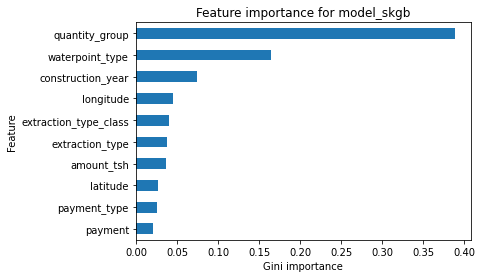

In [15]:
import matplotlib.pyplot as plt

importances = model_skgb.named_steps['gradientboostingclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini importance')
plt.ylabel('Feature')
plt.title('Feature importance for model_skgb');

In [16]:
feat_imp.sum()

1.0

**Option 2:** Drop-column Importance

- Good, but computationally expensive because you have to train a model for each feature.

In [17]:
# Training a model with the feature whose importance we want to evaluate
column = 'quantity_group'

model_w_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=20, n_jobs=-1)
)

model_w_col.fit(X_train, y_train)

print(f'Validation accuracy with {column} included', model_w_col.score(X_val, y_val))

Validation accuracy with quantity_group included 0.7722222222222223


In [19]:
# Training a model with the feature whose importance we want to evaluate
model_wo_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=20, n_jobs=-1)
)

model_wo_col.fit(X_train.drop(columns=column), y_train)

print(f'Validation accuracy with {column} dropped', 
      model_wo_col.score(X_val.drop(columns=column), y_val))

Validation accuracy with quantity_group dropped 0.7376262626262626


In [21]:
print(f'Drop-column importance for {column}:', 0.772 - 0.737)

Drop-column importance for quantity_group: 0.03500000000000003


**Option 3:** Permutation Importance

In [42]:
# By hand
from numpy.random import permutation

# Step 1: Choose a feature
column = 'quantity_group'

# Step 2: Train your model on the whole dataset
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=10, random_state=42, n_jobs=10)
)

model_xgb.fit(X_train, y_train);

# Step 3: Evaluate your validation metrics
print('Validation Accuracy', model_xgb.score(X_val, y_val))

# Step 4: In your validation set, permute the feature you're evaluating
X_val_perm = X_val.copy()
X_val_perm[column] = permutation(X_val_perm[column])

# Step 5: Calculate the error metric with the permuted data
print(f'Validation Accuracy with "{column}" permuted:', model_xgb.score(X_val_perm, y_val))

Validation Accuracy with "quantity_group" permuted: 0.6547979797979798


In [44]:
# Using sklearn
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(model_xgb, X_val, y_val, n_jobs=10, random_state=42)

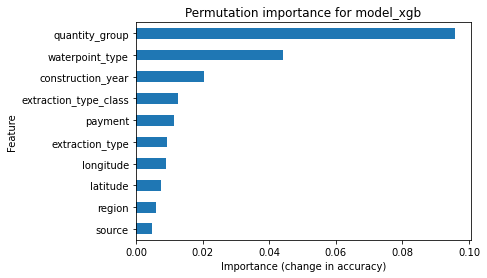

In [53]:
# Put results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('importances_mean', ascending=True, inplace=True)

# Make plot
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');